In [1]:
# %pip install numpy==1.22.0
import numpy as np
from casatasks import *
# from casatools import *
import casatools
import os

from casaplotms import plotms
from casaviewer.imview import imview
import glob
import pandas as pd
from sympy.physics.units.definitions.unit_definitions import oersted
from tqdm import tqdm
msmd = casatools.msmetadata()
ms = casatools.ms()
tb = casatools.table()
import matplotlib as mpl
import matplotlib.pyplot as plt

import subprocess
import re

# %pip install numpy --upgrade


def report_flag(summary,axis):
    for id, stats in summary[ axis ].items():
        print('%s %s: %5.1f percent flagged' % ( axis, id, 100. * stats[ 'flagged' ] / stats[ 'total' ] ))
    pass


def get_spwids(vis):
    lobs = listobs(vis=vis)
    extract_spwids = {key: lobs[key] for key in lobs if 'scan_' in key}

    unique_spwids = set()

    for key in extract_spwids:
        nested_dict = extract_spwids[key]
        for inner_key in nested_dict:
            spwids = nested_dict[inner_key]['SpwIds']
            # Convert the array to a sorted tuple and add to the set
            unique_spwids.add(tuple(sorted(spwids)))

    # Convert the set of tuples back to a sorted list of lists
    unique_spwids_lists = sorted([list(t) for t in unique_spwids])
    # Flatten the list and then convert to a set to get unique elements
    unique_elements = set(element for sublist in unique_spwids_lists for element in sublist)

    # Convert the set back to a list and sort it
    unique_elements_sorted = sorted(list(unique_elements))
    # spw_str_list = get_spwids(vis)
    spw_ids = ','.join(map(str, unique_elements_sorted))
    print('Correct spw ids:',spw_ids)
    return spw_ids

def get_chan_avg_map(vis,chan_out_avg=64):
    msmd.open(vis)
    bandwidth = msmd.bandwidths()
    nspw = len(bandwidth)
    
    chan_freqs_all = np.empty(nspw, dtype=object)
    spws_freq = np.zeros(nspw)
    
    for nch in range(nspw):
        chan_freqs_all[nch] = msmd.chanfreqs(nch)
        spws_freq[nch] = np.nanmean(chan_freqs_all[nch])
    msmd.done()
    mean_freq = np.nanmean(spws_freq) * 1e-9
    shapes = np.asarray([arr.shape[0] for arr in chan_freqs_all])
    # chan_out_avg = 64
    chan_width_avg = list((shapes / chan_out_avg).astype(int))
    return(chan_width_avg)



def get_phase_centre(vis,return_degrees=False):
    
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    msmd.open(vis)
    ra_radians = msmd.phasecenter()['m0']['value']
    dec_radians = msmd.phasecenter()['m1']['value']
    msmd.close()
    # Convert to SkyCoord object
    coord = SkyCoord(ra=ra_radians*u.radian, dec=dec_radians*u.radian, frame='icrs')

    # Format the output using 'hmsdms'
    formatted_coord = coord.to_string('hmsdms')
    formatted_ra, formatted_dec = formatted_coord.split()
    
    formatted_ra_hms = formatted_ra.replace('h', ':').replace('m', ':').replace('s', '')
    formatted_dec_dms = formatted_dec.replace('d', '.').replace('m', '.').replace('s', '')

    formatted_output = "J2000 {} {}".format(formatted_ra_hms, formatted_dec_dms)

    print(formatted_output)
    if return_degrees:
        return(formatted_output,coord.ra.value,coord.dec.value)
    else:
        return(formatted_output)


def calculate_angular_distance(coord1, coord2):
    """
    Calculate the angular distance between two sky coordinates.

    Parameters:
    coord1: tuple of (RA1, Dec1) in degrees
    coord2: tuple of (RA2, Dec2) in degrees

    Returns:
    Angular distance in degrees
    """
    # Convert degrees to radians
    def deg_to_rad(deg):
        return deg * np.pi / 180

    # Extract coordinates
    ra1_deg, dec1_deg = coord1
    ra2_deg, dec2_deg = coord2

    # Convert to radians
    ra1 = deg_to_rad(ra1_deg)
    dec1 = deg_to_rad(dec1_deg)
    ra2 = deg_to_rad(ra2_deg)
    dec2 = deg_to_rad(dec2_deg)

    # Calculate the angular distance
    cos_angle = (np.sin(dec1) * np.sin(dec2) +
                 np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2))
    angular_distance_rad = np.arccos(cos_angle)

    # Convert to degrees
    # angular_distance_deg = angular_distance_rad * 180 / np.pi
    angular_distance_arcseconds = angular_distance_rad * (180 / np.pi) * 3600
    
    return angular_distance_arcseconds

This notebook contain a series of commands to help with data combination. <br>
It works with measurement sets from the same instrument or from different instruments. <br>
Though, it was tested only with e-MERLIN and VLA. <br>

What it does:
- From a reference measurement set, take the phase centre from that and uses to shift the phasecentre according to it
- Calculate the statistical weights and produce a combined visibility with homogeneous weights. Scalling factors ara calculatet using `statwt`.

***This is useful when combining observations of different epochs that have a slightly different phase pointing centre, and also different statistical weights.***

## $\text{VV705 \emph{e}-MERLIN C + VLA-A C}$

The first step is to set what is the reference observation that we are going to use. 
Usually, it should be the one having the higher angular resolution. 

In [2]:
names_or = [
    '/nvme1/scratch/lucatelli/LIRGI_Sample/eMERLIN/LegacyArchive/C_band/VV705/LE1014_C_L26_002_20200315/fields/1518+4244/1518+4244.calibrated.ms',
    '/nvme1/scratch/lucatelli/LIRGI_Sample/VLA-Archive/A_config/C_band/VV705/selfcalibrated_v2/19A-277/standard/VV705_A_C_sf_spw.ms',
           ]

In [3]:
for i in tqdm(range(len(names_or))):
    vis = names_or[i]
    listobs(vis=vis,listfile=names_or[i]+'.listobs',overwrite=True)

100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


In [4]:
vis_list_temp = []
for i in tqdm(range(len(names_or))):
    vis = names_or[i]
    spw_ids_correct = get_spwids(vis)
    try:
        split(vis=vis,
              outputvis=vis.replace('.ms','.temp.ms'),
              spw=spw_ids_correct,
              # timebin='6s',
            #   width=[2],
              datacolumn='data',
              correlation='RR,LL')
    except:
        pass
    vis_list_temp.append(vis.replace('.ms','.temp.ms'))

  0%|          | 0/2 [00:00<?, ?it/s]

Correct spw ids: 0,1,2,3,4,5,6,7


 50%|█████     | 1/2 [00:18<00:18, 18.49s/it]

Correct spw ids: 0,1,2,3,4,5,6,7


100%|██████████| 2/2 [00:42<00:00, 21.29s/it]


Now, we can also average the data in frequency (to 64 channels) to homogenise the number of channels across different measurements (originally 128 for e-MERLIN and 64 for VLA).

This is somewhat critical for observations with different channel widths, but more testing is required.

In [ ]:
vis_list_temp2 = []
for i in tqdm(range(len(vis_list_temp))):
    vis = vis_list_temp[i]
    try:
        chan_width_avg = get_chan_avg_map(vis,chan_out_avg=64)
        # chan_width_avg = chan_width_avg_list[i]
        print(f'Chan avg {chan_width_avg}')
        mstransform(vis=vis,
                    outputvis=vis.replace('.ms','.temp2.ms'),
                    datacolumn='data',
                    keepflags=True,
                    usewtspectrum=True,
                    regridms=False,
                    chanaverage=True,
                    chanbin=chan_width_avg
                    )
        listobs(vis=vis.replace('.ms','.temp2.ms'),
                listfile=vis.replace('.ms','.temp2.ms')+'.listobs',
                overwrite=True)
    except:
        pass
    vis_list_temp2.append(vis.replace('.ms','.temp2.ms'))



  0%|          | 0/2 [00:00<?, ?it/s]

Chan avg [2, 2, 2, 2, 2, 2, 2, 2]


 50%|█████     | 1/2 [00:31<00:31, 31.87s/it]

Chan avg [1, 1, 1, 1, 1, 1, 1, 1]


100%|██████████| 2/2 [01:42<00:00, 51.32s/it]


In [6]:
# vis_list_temp2[0:4]

In [7]:
source_name = 'VV705'
ref_vis = vis_list_temp2[0]
# ref_vis = names_or[0]
ref_info = listobs(vis=ref_vis,listfile=ref_vis+'.listobs',overwrite=True)
file_obs = ref_vis+'.listobs'

In [8]:
# ref_phasecentre = 'J2000 11:28:31.320000 +58.33.41.69999'
ref_phasecentre,ra_deg_ref,dec_deg_ref = get_phase_centre(ref_vis,return_degrees=True)

J2000 15:18:06.12 +42.44.45.1


The next step is to define all other observations of the same band.

In [9]:
# ref_phasecentre = 'J2000 11:28:31.320000 +58.33.41.69999'
vis_list_final =[]
# Shift the phasecentre
for name in vis_list_temp2[1:]:
# for name in names_or[1:]:
    name_shift = name.replace('.ms','')+'_phaseshift.ms'
    vis_list_final.append(name_shift)
    try:
        # old_phasecentre = get_phase_centre(name)
        old_phasecentre,ra_deg_k,dec_deg_k = get_phase_centre(name,return_degrees=True)
        print(f'Processing Visibility: {os.path.basename(name_shift)}')
        print(f"Shifting phasecentre from {old_phasecentre} to {ref_phasecentre}")
        separation_arcsec = calculate_angular_distance((ra_deg_ref,dec_deg_ref), (ra_deg_k,dec_deg_k))
        print(f'Shift difference is {separation_arcsec} arcseconds')
        
        phaseshift(vis=name,phasecenter=ref_phasecentre,
                outputvis=name_shift)
    except:
        pass
vis_list_final.append(ref_vis)

J2000 15:18:06.12999991 +42.44.45.00000507
Processing Visibility: VV705_A_C_sf_spw.temp.temp2_phaseshift.ms
Shifting phasecentre from J2000 15:18:06.12999991 +42.44.45.00000507 to J2000 15:18:06.12 +42.44.45.1
Shift difference is 0.14874373798911192 arcseconds


In [10]:
vis_list_final

['/nvme1/scratch/lucatelli/LIRGI_Sample/VLA-Archive/A_config/C_band/VV705/selfcalibrated_v2/19A-277/standard/VV705_A_C_sf_spw.temp.temp2_phaseshift.ms',
 '/nvme1/scratch/lucatelli/LIRGI_Sample/eMERLIN/LegacyArchive/C_band/VV705/LE1014_C_L26_002_20200315/fields/1518+4244/1518+4244.calibrated.temp.temp2.ms']

In [11]:
list_obs_info = []
for name in tqdm(vis_list_final):
    vis = name + ''
    list_obs_info_i = listobs(vis=vis,listfile=name+'.listobs',overwrite=True)
    list_obs_info.append(list_obs_info_i)
df_lo = pd.DataFrame(list_obs_info)

for i in range(len(df_lo['field_0'])):
    print(df_lo['field_0'][i]['name'])

100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

SDSSJ1518+4244
1518+4244


Next, we run ```statwt``` on each visibility to determine the statistical weights, which tells about the relative scalling of each observation. That will be used to create a visibility where each observation will contribute equally. 

If you have run ```statwt``` just after phase-referencing calibration, you SHOULD set the argument ```preview``` to `True`.

In [12]:
stats = []
for name in tqdm(vis_list_final):
    vis = name + ''
    # stats_i = statwt(vis=vis,preview=False,datacolumn='data',timebin='12s',statalg='chauvenet',chanbin=16, slidetimebin=True)
    stats_i = statwt(vis=vis,preview=True,datacolumn='data',timebin='12s',statalg='chauvenet',
                    #  slidetimebin=True
                     )
    stats.append(stats_i)
df = pd.DataFrame(stats)

100%|██████████| 2/2 [06:13<00:00, 186.64s/it]


In [47]:
stats

[{'mean': 470.5917828263517, 'variance': 28119.68872778273},
 {'mean': 131.83461947862347, 'variance': 12276.028970413588}]

In [30]:
wt_mean = np.mean(df['mean'])
df['mean']
df['wt_factor'] = wt_mean/df['mean']
df['wt_factor']

0    0.640073
1    2.284781
Name: wt_factor, dtype: float64

In [45]:
df['mean']

0    470.591783
1    131.834619
Name: mean, dtype: float64

In [39]:
vis_list_final

['/nvme1/scratch/lucatelli/LIRGI_Sample/VLA-Archive/A_config/C_band/VV705/selfcalibrated_v2/19A-277/standard/VV705_A_C_sf_spw.temp.temp2_phaseshift.ms',
 '/nvme1/scratch/lucatelli/LIRGI_Sample/eMERLIN/LegacyArchive/C_band/VV705/LE1014_C_L26_002_20200315/fields/1518+4244/1518+4244.calibrated.temp.temp2.ms']

In [26]:
concatvis=f'./{source_name}_eM_EVLA_C.ms'
concat(vis=vis_list_final,
       concatvis=concatvis,dirtol='1000.0arcsec',copypointing=True,timesort=True,
       freqtol='1MHz',visweightscale=list(df['wt_factor'])
      )
_ = listobs(vis=concatvis,listfile=concatvis+'.listobs',overwrite=True)

In [44]:
concatvis_noscale=f'./{source_name}_eM_EVLA_C_noscale.ms'
concat(vis=vis_list_final,
       concatvis=concatvis_noscale,dirtol='1000.0arcsec',copypointing=True,timesort=True,
       freqtol='1MHz',
      )
_ = listobs(vis=concatvis_noscale,listfile=concatvis_noscale+'.listobs',overwrite=True)

In [27]:
spw_ids = get_spwids(concatvis)

Correct spw ids: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15


In [ ]:
outputvis = concatvis.replace('.ms','.avg4s.ms')
mstransform(vis=concatvis,
      outputvis=outputvis,
      datacolumn='data',
      # timebin='12s',
      # timeaverage=True,
      # correlation='RR,LL',
      usewtspectrum=True,
      spw=spw_ids,
      keepflags=True)
_ = listobs(vis=outputvis,listfile=outputvis+'.listobs',overwrite=True)

In [40]:
plotms(vis=outputvis,xaxis='uwave',yaxis='vwave',coloraxis='observation',
       avgtime='60',avgchannel='8'
       )

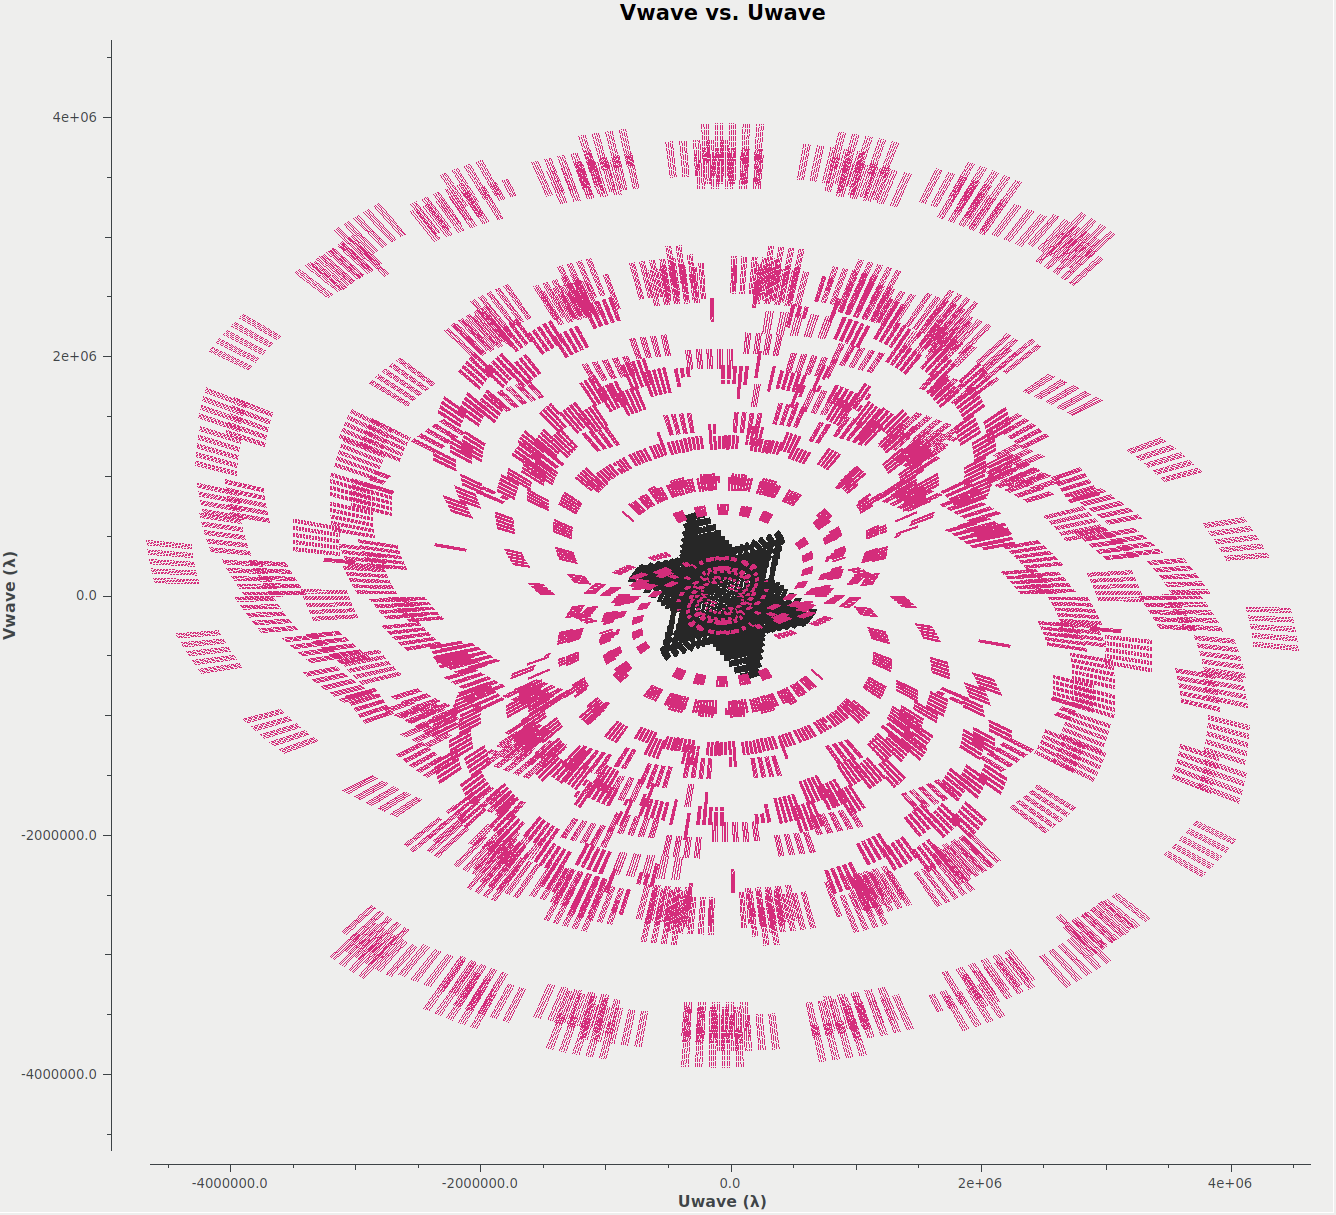

In [ ]:
def plot_uv_wavelength(vis, color='black', 
                       chunk_size=int(4), downsample_factor=int(4),
                      fig=None, ax=None, alpha=1.0, figsize=(10,10)):
    """
    Plot UV wavelength (uwave vs vwave) for radio interferometric data.
    
    Parameters:
    -----------
    vis : str
        Path to measurement set (MS) file
    color : str, optional
        Color of the plot points
    chunk_size : int, optional
        Size of chunks for frequency averaging
    downsample_factor : int, optional
        Factor by which to downsample the data points
    fig : matplotlib.figure.Figure, optional
        Existing figure to plot on
    ax : matplotlib.axes.Axes, optional
        Existing axes to plot on
    alpha : float, optional
        Transparency of plot points
    figsize : tuple, optional
        Figure size if creating new figure
        
    Returns:
    --------
    fig, ax : tuple
        Matplotlib figure and axes objects
    """
    LIGHT_SPEED = 299792458.0  # speed of light in m/s
    
    def get_baseline_info(ant1, ant2, ant_uniq):
        """Create dictionary mapping baseline pairs to data indices."""
        return {(x, y): np.where((ant1 == x) & (ant2 == y))[0]
                for x in ant_uniq for y in ant_uniq if y > x}
    
    # # Read frequency information
    # with table(vis + '::SPECTRAL_WINDOW') as spw:
    #     chan_freq = spw.getcol('CHAN_FREQ').flatten()
    
    # # Read visibility and antenna data
    # with table(vis) as tb:
    #     uvw = tb.getcol('UVW')
    #     ant1 = tb.getcol('ANTENNA1')
    #     ant2 = tb.getcol('ANTENNA2')
    #     flag = tb.getcol('FLAG')
    #     flag_row = tb.getcol('FLAG_ROW')
    
    # # Read station names
    # with table(vis + '::ANTENNA') as ant_tb:
    #     station = ant_tb.getcol('STATION')

    ms.open(vis)
    mydata = ms.getdata(['axis_info'])
    chan_freq = mydata['axis_info']['freq_axis']['chan_freq'].flatten()
    ms.close()
    
    #vis and antenna info
    tb.open(vis)
    uvw = tb.getcol('UVW')
    ant1 = tb.getcol('ANTENNA1')
    ant2 = tb.getcol('ANTENNA2')
    flag = tb.getcol('FLAG')
    flag_row = tb.getcol('FLAG_ROW')
    tb.close()
    tb.open(vis+'::ANTENNA')
    station = tb.getcol('STATION')
    tb.close()
    
    # Get unique antennas and create baseline dictionary
    ant_uniq = np.unique(np.hstack((ant1, ant2)))
    baseline_dict = get_baseline_info(ant1, ant2, ant_uniq)
    
    # Create station labels dictionary
    labels = {bl: f"{station[bl[0]]}-{station[bl[1]]}" 
             for bl in baseline_dict.keys()}
    
    if fig is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    
    # Prepare frequency blocks for averaging
    n_chunks = len(chan_freq) // chunk_size
    freq_chunks = chan_freq.reshape((n_chunks, chunk_size))
    chunk_freqs = freq_chunks.mean(axis=1)
    wavelengths = (LIGHT_SPEED / chunk_freqs.reshape(-1, 1)) * 1e3  # in Klambda
    
    # Plot each baseline
    for baseline in tqdm(list(baseline_dict.keys())):
        # Get baseline indices
        bl_indices = baseline_dict[baseline]
        
        # Extract u,v coordinates
        u = uvw[0, bl_indices]
        v = uvw[1, bl_indices]
        
        # Create conjugate points
        # u_points = np.tile(np.hstack([u, np.nan, -u]), (n_chunks, 1)) / wavelengths
        # v_points = np.tile(np.hstack([v, np.nan, -v]), (n_chunks, 1)) / wavelengths
        u_points = np.tile(np.hstack([u, -u]), (n_chunks, 1)) / wavelengths
        v_points = np.tile(np.hstack([v, -v]), (n_chunks, 1)) / wavelengths

        
        # Plot with downsampling
        ax.plot(u_points[:, ::downsample_factor], 
                v_points[:, ::downsample_factor],
                '.', markersize=0.1, color=color, alpha=alpha)
    
    return fig, ax

100%|██████████| 528/528 [00:44<00:00, 11.84it/s]


(-4829.669993178486, 4829.579819027051, -4250.235557878137, 4250.238859638317)

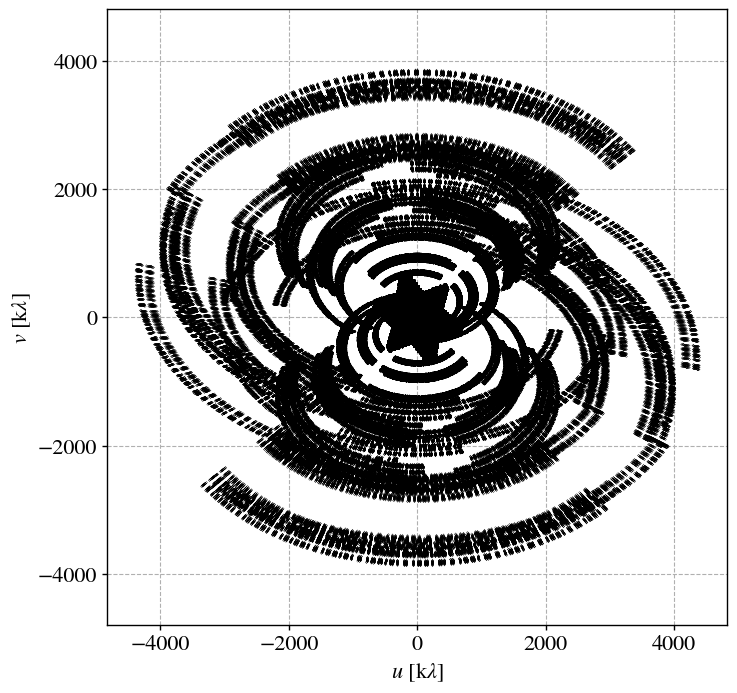

In [42]:
# concatvis=f'./{source_name}_eM_EVLA_L.ms'
fig,ax = plot_uv_wavelength(vis=outputvis,
                          color='black',figsize=(8,8),
                          chunk_size=int(2), downsample_factor=int(150)
                         )
ax.set_xlabel('$u$ [k$\lambda$]')
ax.set_ylabel('$v$ [k$\lambda$]')
plt.grid()
ax.axis('equal')

In [54]:
for i in range(len(vis_list_temp)):
    print('Removing temporary visibility files.')
    os.system(f'rm -r {vis_list_temp[i]}')
    os.system(f'rm -r {vis_list_temp2[i]}')
    os.system(f'rm -r {vis_list_final[i]}')
    

Removing temporary visibility files.
Removing temporary visibility files.
